In [254]:
import pandas as pd
import numpy as np
import random

# DataFrame Creation

In [255]:
SEED = 42 # answer to everything
# Don't really need reproducibility rn.
# np.random.seed(SEED)
# random.seed(SEED)

LABELLED_FRAC = 0.3
N_TRAIN_SAMPLES = 10000
N_SAMPLES = int(N_TRAIN_SAMPLES // LABELLED_FRAC)
print(f"Total number of samples: {N_SAMPLES}")

ID_VARIABLE_NAME = "ID" # Name of the ID variable BEFORE RENAME.
TARGET_VARIABLE_NAME = "y" # Name of the target BEFORE RENAME.

INITIAL_NOISE = 0.05
FINAL_NOISE = 0.05

CAT_ERROR_PROB = 0.1 # Probability of categorical error
LABELLED_NAN_FRAC = 0.08
UNLABELED_NAN_FRAC = 0.15

LABELLED_DUPLICATE_FRAC = 0.2 # Fraction of rows to duplicate

ARTIFICIAL_TARGET_MULTIPLIER = 1000

DATA_DIR = "data"

Total number of samples: 33333


In [256]:
class cds:
    def __init__(self, weight: int, name: str) -> None:
        self.weight = weight
        self.name = name
        
        # Castes: Nominal
        castes = ['jut', 'kiv', 'tir', 'vel', 'qou']
        castes_f = [30, 25, 25, 20, 40]
        castes_p = [f / sum(castes_f) for f in castes_f]
        caste_col = np.random.choice(castes, N_SAMPLES, p=castes_p)

        # Matter: Ordinal
        matter = { # frequency, strength
            'corro': (6, 0),
            'corroyi': (5, 1),
            'sfer': (5, 2),
            'black corru': (3, 4),
            'corruskivi': (2, 10),
            'corrutir': (1, 11),
            'corrutir vel': (1, 12),
            'satik cyst': (5, 15),
            'pale corru': (1, 100),
        }
        matter_f_sum = sum(freq for freq, _ in matter.values())
        matter_p = [freq / matter_f_sum for freq, _ in matter.values()]
        matter_names = list(matter.keys())
        matter_col = np.random.choice(
            matter_names,
            N_SAMPLES,
            p=matter_p
        )

        # Mindspike: Ordinal
        mindspike_versions = {'tonga': 0, 'karbon': 10, 'silikon': 20, 'kristal': 30, 'nan': 40} # Replace 'nan' with an actual NaN later.
        mindspike_v_col = np.random.choice(
            list(mindspike_versions.keys()),
            N_SAMPLES,
            p=[0.1, 0.2, 0.2, 0.4, 0.1]
        )

        effect_matter = np.array([matter[m_name][1] for m_name in matter_col]) # Get strength values
        effect_mindspike = np.array([mindspike_versions[m_name] for m_name in mindspike_v_col]) # Get version values
        y = effect_matter + effect_mindspike

        for i in range(N_SAMPLES):
            match caste_col[i]:
                case 'jut':
                    y[i] *= 5
                case 'kiv':
                    y[i] *= 0.5
                case 'tir':
                    y[i] *= 0.75
                case 'vel':
                    y[i] = np.sin(y[i])
                case 'qou':
                    y[i] *= 10
        
        # Normalize y to [0, 1]
        min_y = y.min()
        max_y = y.max()
        y = (y - min_y) / (max_y - min_y)

        self.X = pd.DataFrame({
            'caste': caste_col,
            'matter': matter_col,
            'mindspike': mindspike_v_col,
        })
        self.y = pd.Series(y, name=f'{self.name}_y')

        # Replace 'nan' string in mindspike with actual NaN
        self.X['mindspike'] = self.X['mindspike'].replace('nan', np.nan)

        # Induce categorical errors
        n_rows = self.X.shape[0]
        n_cat_errors = int(n_rows * CAT_ERROR_PROB)

        # Randomly choose pairs of indices
        error_row_indices = np.random.choice(self.X.index, n_cat_errors, replace=True)

        for idx in error_row_indices:
            match np.random.choice(2):
                case 0:
                    caste_val = self.X.at[idx, 'caste']
                    if isinstance(caste_val, str) and not caste_val.endswith('skin'):
                        self.X.at[idx, 'caste'] = caste_val + 'skin'
                case 1:
                    self.X.at[idx, 'mindspike'] = 'ERROR'

In [ ]:
from sklearn.datasets import (
    make_moons, make_circles, make_blobs, make_classification, make_hastie_10_2,
    make_friedman1, make_friedman2, make_friedman3, make_regression
)
from typing import Callable

class ds:
    def __init__(self, weight: float, name: str, generator: Callable[[], tuple[np.ndarray, np.ndarray]]):
        self.weight: float = weight
        self.name: str = name

        self.raw_X: np.ndarray
        self.raw_y: np.ndarray
        self.raw_X, self.raw_y = generator()

        min_y = self.raw_y.min()
        max_y = self.raw_y.max()
        if min_y == max_y:
            self.raw_y = np.zeros_like(self.raw_y)
        else:
            self.raw_y = (self.raw_y - min_y) / (max_y - min_y)  # Normalize y to [0, 1]

        self.X: pd.DataFrame = pd.DataFrame(
            self.raw_X,
            columns=[
                f"{self.name}_{i+1}" for i in range(self.raw_X.shape[1])
            ]
        )
        self.y: pd.Series = pd.Series(self.raw_y, name="{self.name}_y")

    
    def __hash__(self):
        return hash(self.name)

    def __eq__(self, other):
        return isinstance(other, ds) and self.name == other.name

# Make sure each has a unique name.
DATASETS: list[ds | cds] = [
    cds(9, "cat"),
    ds(4, "moon",      lambda: make_moons(n_samples=N_SAMPLES, noise=INITIAL_NOISE, random_state=SEED)),
    ds(3, "circle",    lambda: make_circles(n_samples=N_SAMPLES, noise=INITIAL_NOISE, factor=0.6, random_state=SEED)),
    ds(2, "blob",      lambda: make_blobs(n_samples=N_SAMPLES, centers=3, n_features=2, random_state=SEED, return_centers=False)), # type: ignore # return_centers=False to avoid returning centers
    ds(2, "hastie",    lambda: make_hastie_10_2(n_samples=N_SAMPLES, random_state=SEED)),
    ds(2, "friedman1", lambda: make_friedman1(n_samples=N_SAMPLES, n_features=7, noise=INITIAL_NOISE, random_state=SEED)),
    ds(2, "friedman2", lambda: make_friedman2(n_samples=N_SAMPLES, noise=INITIAL_NOISE, random_state=SEED)),
    ds(2, "friedman3", lambda: make_friedman3(n_samples=N_SAMPLES, noise=INITIAL_NOISE, random_state=SEED)),
    ds(1, "class",     lambda: make_classification(n_samples=N_SAMPLES, n_features=7, n_informative=3, n_redundant=2, n_repeated=2, n_classes=4, class_sep=0.5, flip_y=0.2, weights=[0.6, 0.2, 0.1, 0.1], random_state=SEED)),
    ds(1, "reg",       lambda: make_regression(n_samples=N_SAMPLES, n_features=5, n_informative=2, noise=INITIAL_NOISE, random_state=SEED, coef=False)), # type: ignore # coef=False to avoid returning coefficients
]

In [258]:
df = pd.concat([d.X for d in DATASETS], axis=1)
df = df.sample(frac=1, random_state=SEED).reset_index(drop=True) # Shuffle rows, just in case.

normalized_weights = np.array([d.weight for d in DATASETS], dtype=np.float64) # dtype=np.float64 for division in the next line
normalized_weights /= normalized_weights.sum()
y_final = sum(DATASETS[i].y * normalized_weights[i] for i in range(len(DATASETS)))
y_final += np.random.normal(0, FINAL_NOISE, size= N_SAMPLES) # Some small, random noise to the final target
df[TARGET_VARIABLE_NAME] = y_final * ARTIFICIAL_TARGET_MULTIPLIER # Scale the target to a larger range for larger RMSEs

id = pd.Series(np.arange(df.shape[0]), name=ID_VARIABLE_NAME)
df[ID_VARIABLE_NAME] = id
# Making sure the ID column is the first column; makes the analysis prettier.
cols = [ID_VARIABLE_NAME] + [col for col in df.columns if col != ID_VARIABLE_NAME]
df = df[cols]

# Analysis

In [259]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: >

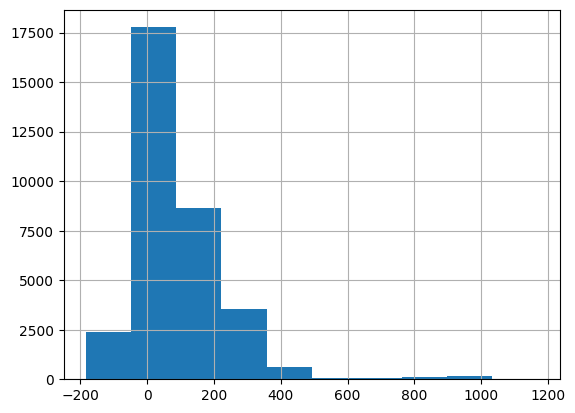

In [260]:
df[TARGET_VARIABLE_NAME].hist()

In [261]:
df.head()

,ID,caste,matter,mindspike,y
0,0,vel,black corru,NaN,-39.286042
1,1,tir,corroyi,silikon,212.535812
2,2,qou,corruskivi,karbon,43.295020
3,3,tir,corroyi,karbon,-71.867297
4,4,kiv,black corru,kristal,-51.208544


In [262]:
# Numerical and categorical columns
num_cols = df.select_dtypes(exclude=['object']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

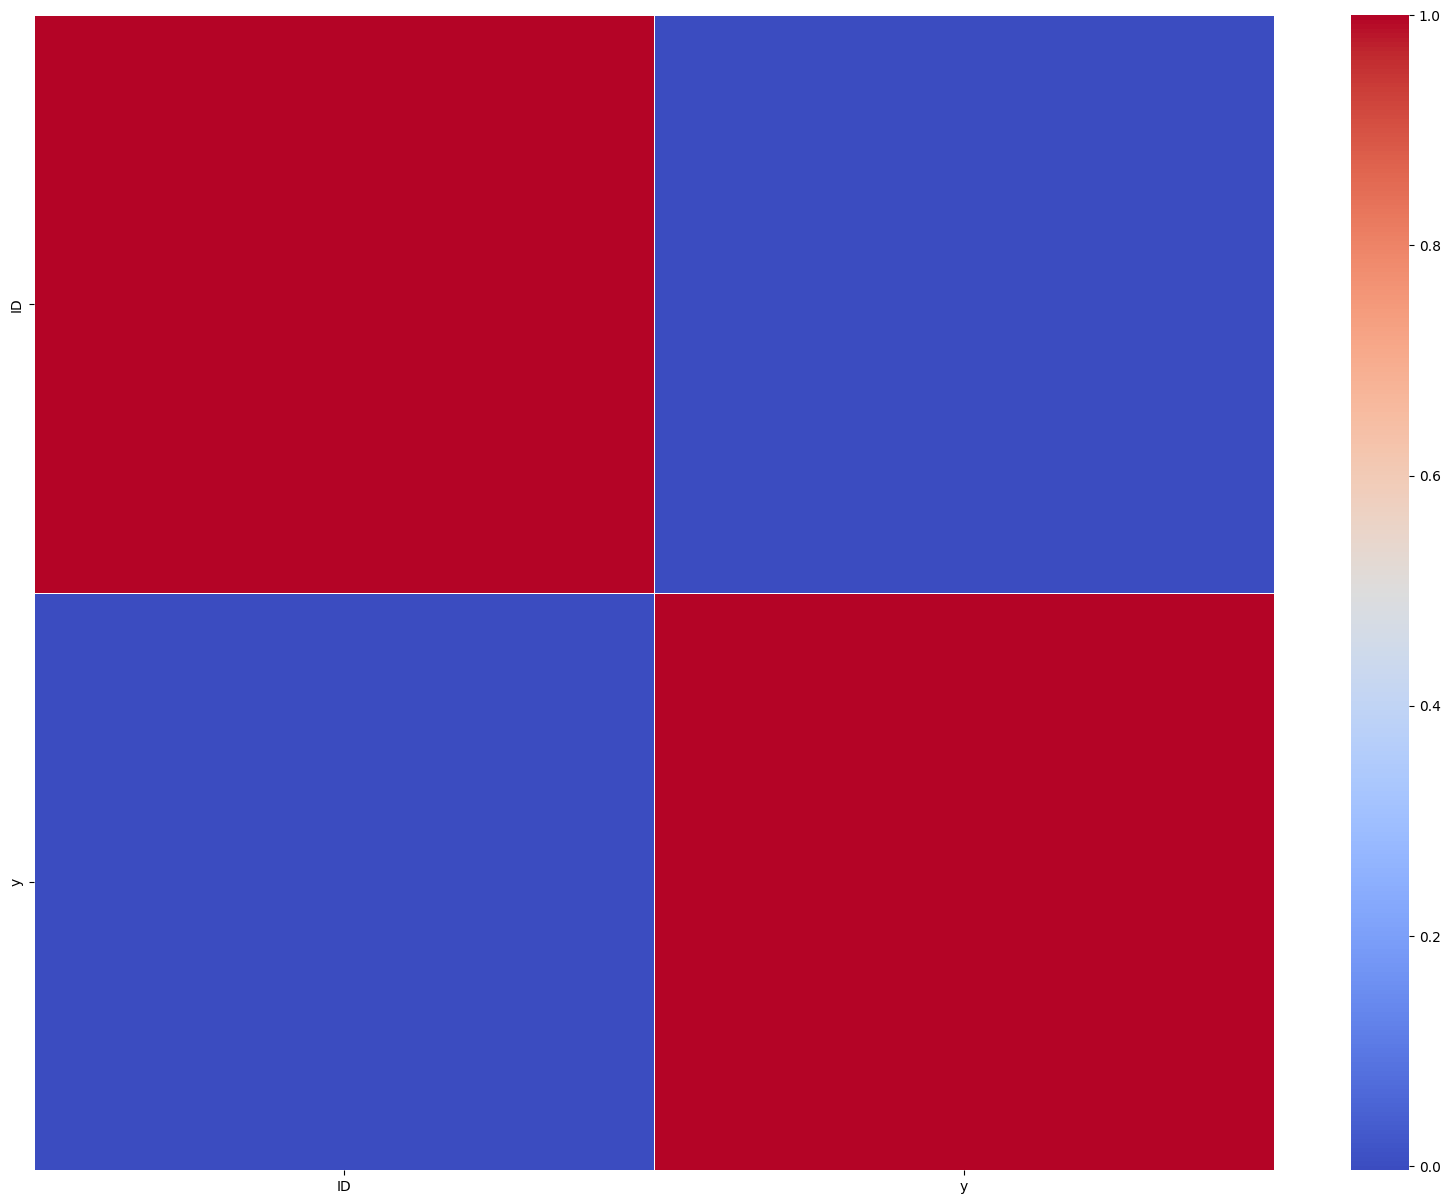

In [263]:
# Correlogram
temp = df.drop(columns=cat_cols)
correlation_matrix = temp.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap="coolwarm", cbar=True, linewidths=0.5)
plt.show()

ValueError: Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.

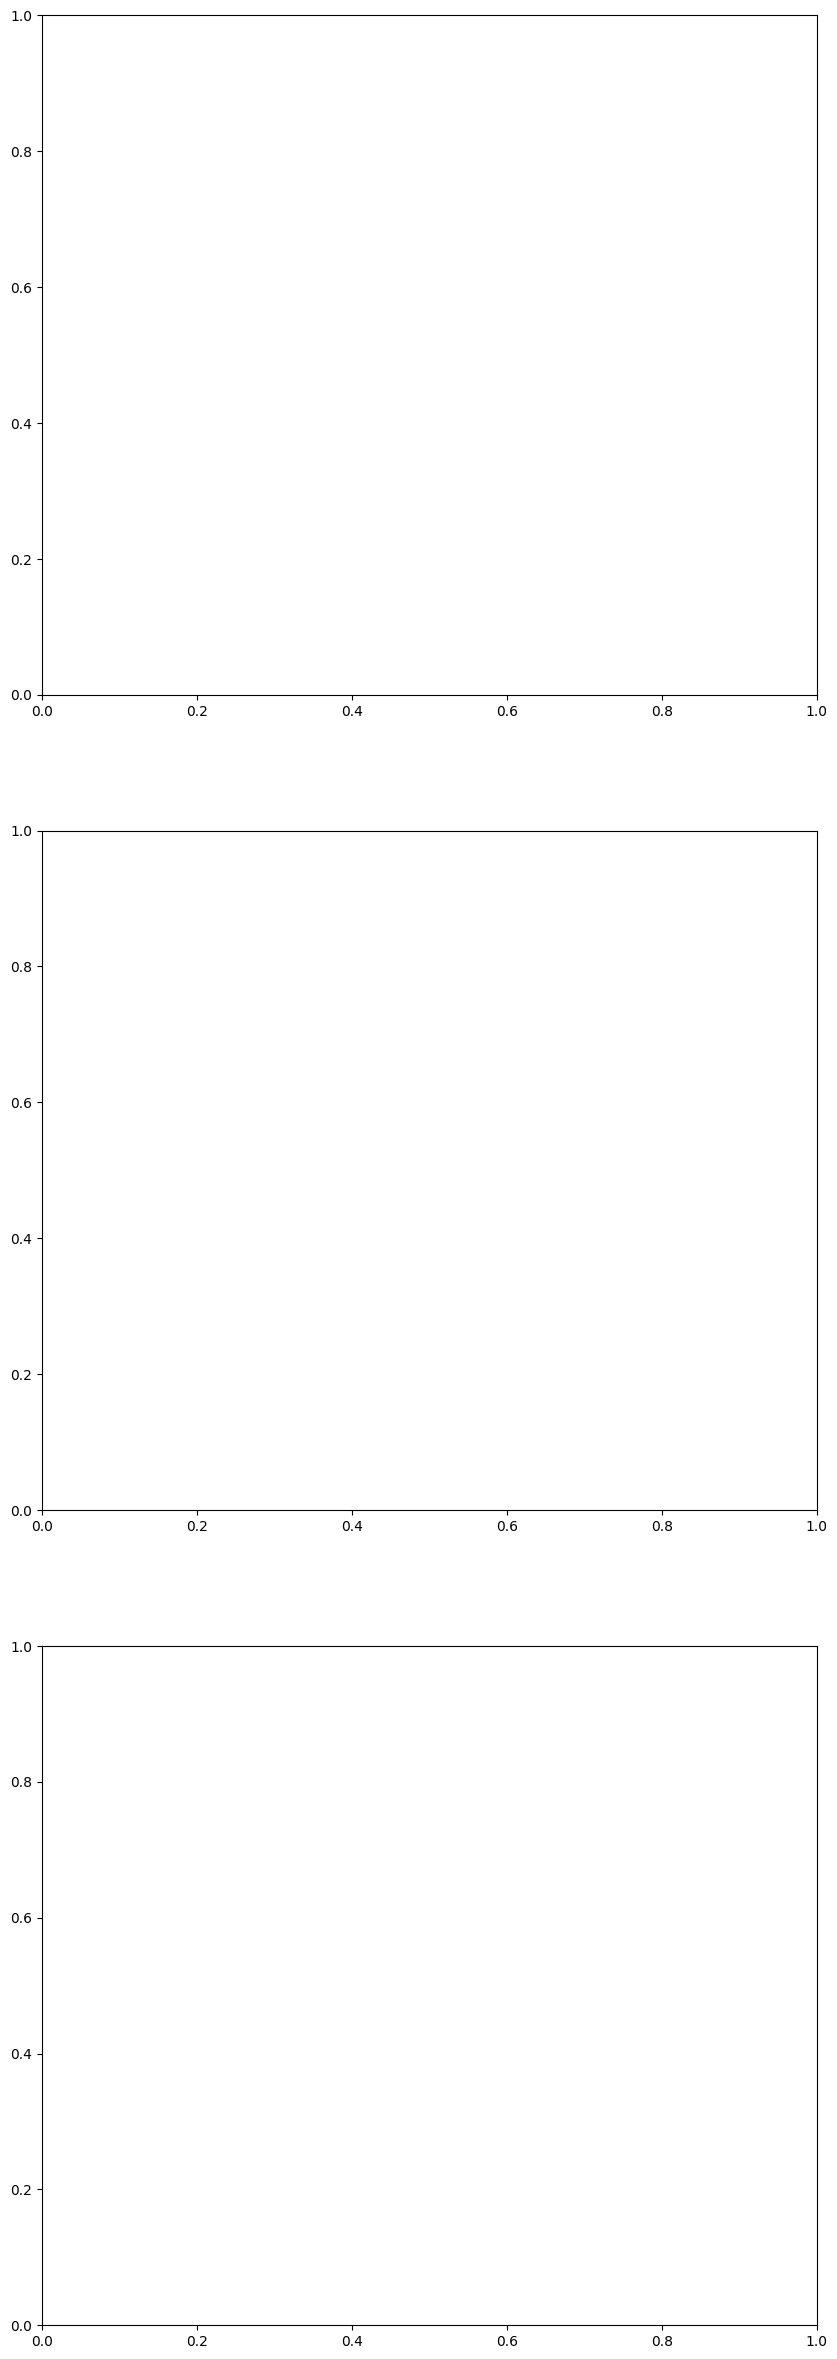

In [264]:
# xgboost feature importance
from xgboost import plot_importance, XGBRegressor

X1 = pd.DataFrame(df[num_cols].drop(columns=[TARGET_VARIABLE_NAME, ID_VARIABLE_NAME]), columns=df.columns, index=df.index)
model = XGBRegressor()
model.fit(X1, df[TARGET_VARIABLE_NAME])

fig, axs = plt.subplots(3, 1, figsize=(10, 30))
for ax, importance_type in zip(axs, ['weight', 'gain', 'cover']):
    plot_importance(model, ax=ax, importance_type = importance_type, title = importance_type)
plt.show()

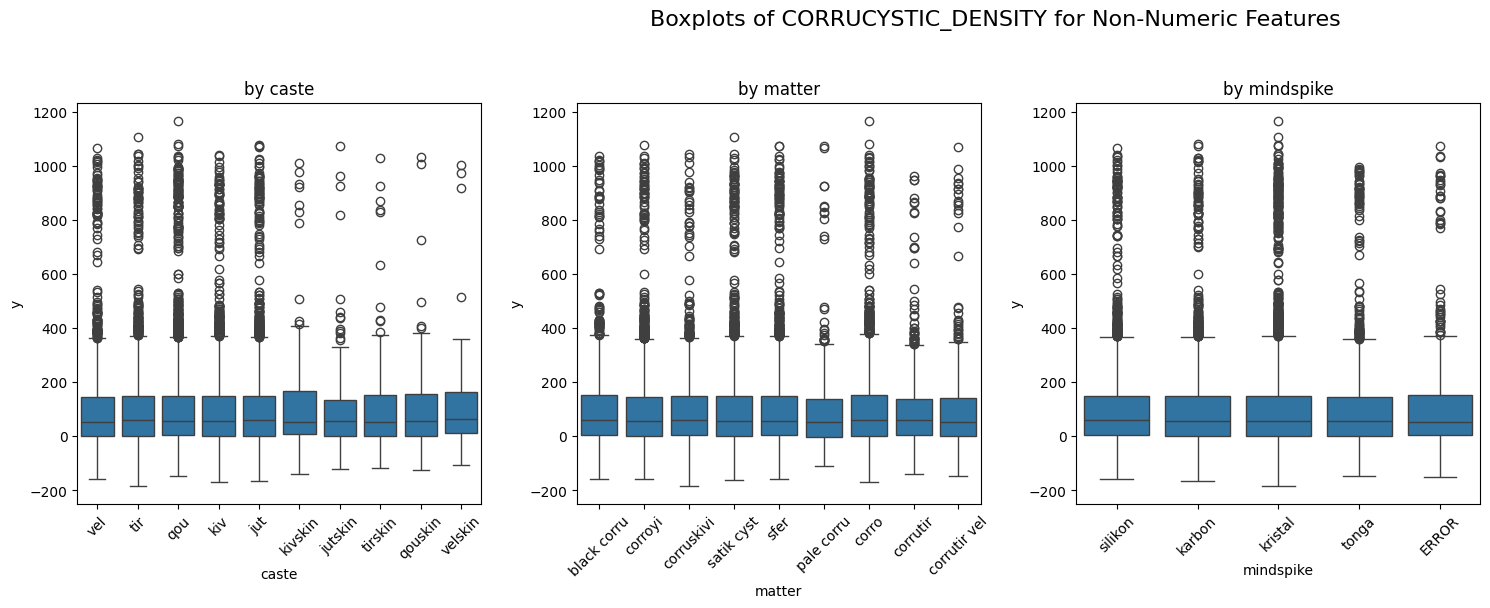

In [265]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle(f'Boxplots of CORRUCYSTIC_DENSITY for Non-Numeric Features', fontsize=16, y=1.02)
axes = axes.flatten()

for i, feature in enumerate(cat_cols):
    ax = axes[i]
    sns.boxplot(data=df, x=feature, y=TARGET_VARIABLE_NAME, ax=ax)
    ax.set_title(f'by {feature}')
    ax.tick_params(axis='x', rotation=45)
    
# Hide any unused subplots
for j in range(len(cat_cols), len(axes)):
    axes[j].set_visible(False)
    
plt.tight_layout()
plt.show()

# CSV Creation

In [ ]:
# Column shuffling with the target column at the end and ID at the beginning
cols = df.columns.tolist()
df = df[[cols[0]] + np.random.permutation(cols[1:-1]).tolist() + [cols[-1]]]
df.columns

Index(['ID', 'class_6', 'class_2', 'reg_1', 'class_3', 'class_7', 'class_4',
       'class_1', 'mindspike', 'class_5', 'caste', 'reg_4', 'matter', 'reg_3',
       'reg_2', 'reg_5', 'y'],
      dtype='object')

In [ ]:
# Column renaming
renaming = {
    ID_VARIABLE_NAME: 'LOCAL_IDENTIFIER',
    TARGET_VARIABLE_NAME: 'CORRUCYSTIC_DENSITY',

    'moon_1': 'v0rt3X',
    'moon_2': 'v1rt3X',
    'circle_1': 'r1Ng',
    'circle_2': 'r2Ng',
    'blob_1': 'b1oRb13',
    'blob_2': 'b2oRb13',

    'mindspike': 'MINDSPIKE_VERSION',
    'matter': 'maT_r',
}

generic_cols = [col for col in df.columns if col not in renaming]

import string

def random_gibberish(mean_length: int = 4, std_length = 3) -> str:
    length = max(3, int(round(random.gauss(mean_length, std_length))))
    chars = string.ascii_letters + string.digits + string.punctuation
    return ''.join(random.choice(chars) for _ in range(length))

gibberish_mapping = {col: random_gibberish() for col in generic_cols}

final_mapping = {**renaming, **gibberish_mapping}

df.rename(columns=final_mapping, inplace=True)
df.columns

Index(['LOCAL_IDENTIFIER', ')Nu', '(pJ', '0.W$x\', 'f-y:3', 'YyQHGbLt', 'ucN',
       '!Uj', 'MINDSPIKE_VERSION', '1d+', ';NC', ''uV^b', 'maT_r', '<(-"=dU',
       '>23d', 't[SP', 'CORRUCYSTIC_DENSITY'],
      dtype='object')

In [ ]:
labelled = df.iloc[:N_TRAIN_SAMPLES]
unlabelled = df.iloc[N_TRAIN_SAMPLES:]

In [ ]:
# Add duplicate rows to the training set alone
print(f'Labeleld dataset shape before duplication: {labelled.shape}')
rows_to_duplicate = labelled.sample(frac=LABELLED_DUPLICATE_FRAC, replace=False, random_state=SEED)
labelled = pd.concat([labelled, rows_to_duplicate], ignore_index=True)
labelled = labelled.sample(frac=1) # Shuffle the training set
print(f'Labeleld dataset shape after duplication: {labelled.shape}')

Labeleld dataset shape before duplication: (10000, 17)
Labeleld dataset shape after duplication: (12000, 17)


In [ ]:
# Check for duplicates
assert labelled.drop(columns=[renaming[ID_VARIABLE_NAME]]).duplicated().any()

In [ ]:
# Renumber the IDs in both sets
labelled = labelled.reset_index(drop=True)
labelled[renaming[ID_VARIABLE_NAME]] = np.arange(len(labelled))

unlabelled = unlabelled.reset_index(drop=True)
unlabelled[renaming[ID_VARIABLE_NAME]] = np.arange(len(unlabelled))

In [ ]:
# Populate NaNs
# WARNING: Renaming has taken place.

def add_nans(df: pd.DataFrame, prob: float, dont_add_on_target: bool = False) -> pd.DataFrame:
    rng = np.random.default_rng(SEED)
    df = df.copy()

    id_col = renaming[ID_VARIABLE_NAME]
    target_col = renaming[TARGET_VARIABLE_NAME]

    maskable_cols = [c for c in df.columns if c != id_col and not (dont_add_on_target and c == target_col)]
    n_rows = len(df)
    n_cols = len(maskable_cols)

    if n_rows == 0 or n_cols == 0 or prob <= 0:
        return df

    # Create a boolean mask for all maskable cells
    mask = rng.random((n_rows, n_cols)) < prob
    df.loc[:, maskable_cols] = df.loc[:, maskable_cols].mask(mask)

    return df

labelled = add_nans(labelled, prob=LABELLED_NAN_FRAC, dont_add_on_target=False)
unlabelled = add_nans(unlabelled, prob=UNLABELED_NAN_FRAC, dont_add_on_target=True)

In [ ]:
unlabelled

,LOCAL_IDENTIFIER,)Nu,(pJ,0.W$x\,f-y:3,YyQHGbLt,ucN,!Uj,MINDSPIKE_VERSION,1d+,;NC,'uV^b,maT_r,"<(-""=dU",>23d,t[SP,CORRUCYSTIC_DENSITY
0,0,-1.028428,1.264009,0.464300,1.264009,NaN,1.501042,-1.061418,silikon,NaN,qou,-1.142284,satik cyst,0.006870,0.955047,-1.367293,90.912037
1,1,1.403662,-1.581587,NaN,-1.581587,0.701069,-1.606526,0.701069,kristal,1.064532,qou,1.194240,sfer,NaN,-1.042269,-1.930202,55.158823
2,2,-0.786282,0.831174,0.366504,0.831174,0.335245,0.473402,NaN,silikon,0.143142,vel,0.365240,satik cyst,0.703049,-0.962316,-0.217233,100.341266
3,3,0.180936,-2.142551,-1.439199,-2.142551,NaN,-0.453412,NaN,NaN,-3.128826,tir,2.872461,corroyi,0.694802,NaN,NaN,179.168555
4,4,-1.006998,0.130337,0.604597,0.130337,0.239110,0.672689,0.239110,silikon,NaN,tir,-2.325966,black corru,0.554076,-0.016481,NaN,103.747722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23328,23328,-0.524441,0.536644,0.890150,0.536644,0.558329,0.119989,NaN,NaN,0.449206,jut,-0.221428,corroyi,0.973809,1.483738,0.157385,73.939606
23329,23329,-0.033982,-0.007421,-1.250543,-0.007421,0.003898,0.024568,0.003898,kristal,-0.085894,jutskin,0.790086,corro,1.105659,-0.100019,1.236121,186.949145
23330,23330,-0.677822,NaN,-1.121040,0.632705,-0.092482,NaN,-0.092482,kristal,-0.471416,NaN,-0.699468,satik cyst,0.930135,NaN,0.250103,152.934070
23331,23331,0.814608,-0.012231,-1.173880,-0.012231,-0.807215,-0.182311,-0.807215,kristal,0.884748,jut,2.067906,corrutir,-0.197938,-1.831682,-1.051310,18.270801


In [ ]:
# Save the datasets to CSV files
from datetime import datetime
from os import makedirs
from shutil import rmtree
timestamp = datetime.now().strftime("%dT%H%M%S")
rmtree(DATA_DIR)  # Remove the old directory if it exists # comment out if you want to keep the old data
makedirs(f"{DATA_DIR}/{timestamp}", exist_ok=True) # Create directory if it doesn't exist

unlabelled_answers = unlabelled[[renaming[ID_VARIABLE_NAME], renaming[TARGET_VARIABLE_NAME]]].copy()
unlabelled.drop(columns=[renaming[TARGET_VARIABLE_NAME]], inplace=True)
labelled.to_csv(f"{DATA_DIR}/{timestamp}/labelled.csv", index=False)
unlabelled.to_csv(f"{DATA_DIR}/{timestamp}/unlabelled.csv", index=False)
unlabelled_answers.to_csv(f"{DATA_DIR}/{timestamp}/unlabelled_answers.csv", index=False)